In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM
import sklearn.ensemble             # RandomForestClassifier, VotingClassifier

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Tensorflow not available - excluding packets relying on it!


__Notebook config__

In [4]:
NB_EXPERIMENT = "power-cc_interference_nose"

environments_to_execute = [
    "Haswell",
    "Sandy"
]

phases = {
    "Haswell": {
        "normal": ["train", "eval"],
    },
    "Sandy": {
        "normal": ["train", "eval"],
    },
}

In [5]:
raise Exception("Are you sure?")

Exception: Are you sure?

# Generate Experiment
1. Load the configuration and define phases and environments

In [ ]:
config = TOML.load(f"configurations/{NB_EXPERIMENT}.toml")
print(TOML.dumps(config))

2. Instantiate, generate and write the experiment

In [ ]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()

# If exists...
if PATH.Path(f"data/{NB_EXPERIMENT}/").exists():
    # First move...
    experiment.config.experiment_exists_action = "move"
    experiment.write()

# Then set to update mode.
experiment.config.experiment_exists_action = "update"
experiment.write()

## Execute

Running `execute` will execute in all environments present in the configuration.

Show phases' durations.

In [ ]:
experiment.print_duration()

_Optionally_ peek at execution status. The execution status can be modified manually or via `_modify_execution_status`. If a modification has been made, push it to run instances with `_push_execution_status`. To rerun or resume execution, set the _resume_ argument to `True`.

In [ ]:
execution_status = experiment._execution_status

for _platform in phases:
    for phase, runs in execution_status.items():
        for run, statuses in runs.items():
            for platform, status in statuses:
                if _platform == platform and _platform in phase:
                    print(
                        "{}Phase: {:>20s} Run: {:3d} Platform: {:>8s} Status: {}".format(
                            "✓ " if any(status) else "✗ ", phase, run, platform, status
                        )
                    )

Finally, execute sequentially in all environments.

In [ ]:
raise Exception("Are you sure?")

In [ ]:
for env in environments_to_execute:
    for phase in phases[env].items():
         experiment.execute_in_environment(env, phase, resume=False)
experiment.write()

# Demo
With the following cell you can visualise a single run from either platform and also have a look on the data histogram, to check whether the quantisation thresholds are defined correctly.

2020-03-30 18:43:56 :: unpicked an experiment instance <PerformanceExperiment at 0x7f94aeb0fbe0 with PowerCC channel, configured>
2020-03-30 18:43:56 :: configs from pickle and directory differ at [{'path': ('save_path',), 'left': 'data', 'right': './data'}]
2020-03-30 18:43:57 :: environments from pickle and directory differ at [{'path': ('Sandy', 'host', 'power_thresholds', 'pp0'), 'left': [0.0, 35.0, 39.0, 43.0, 47.0, 50.5, 53.75, 57.5, 61.0], 'right': [0.0, 35.0, 40.0, 43.0, 47.0, 51.0, 55.0, 58.0, 62.0]}]
2020-03-30 18:43:57 :: git commit of unpickled experiment repo '72570632' does not match the commit in which the unpickling was performed 'b9fe78b3'
2020-03-30 18:43:57 :: bootstrapped layer 'src' with SourcePassthrough
2020-03-30 18:43:57 :: bootstrapped layer 'lne' with MedianLineCoding
2020-03-30 18:43:57 :: bootstrapped layer 'rdp' with QuantCoreActivation
2020-03-30 18:43:57 :: bootstrapped layer 'io' with TimeValue


(0, 70)

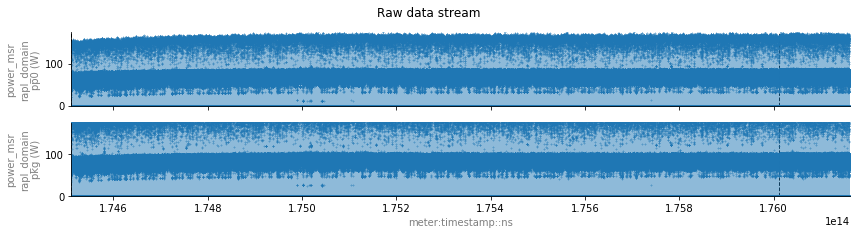

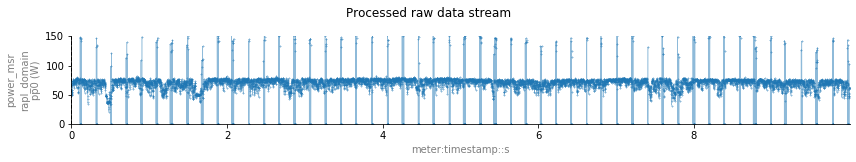

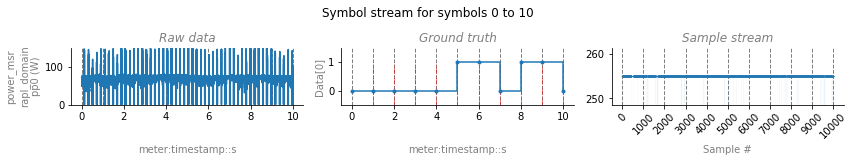

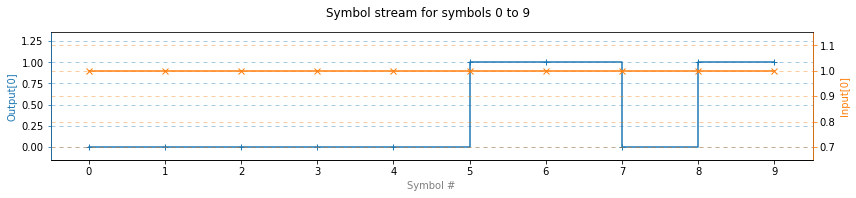

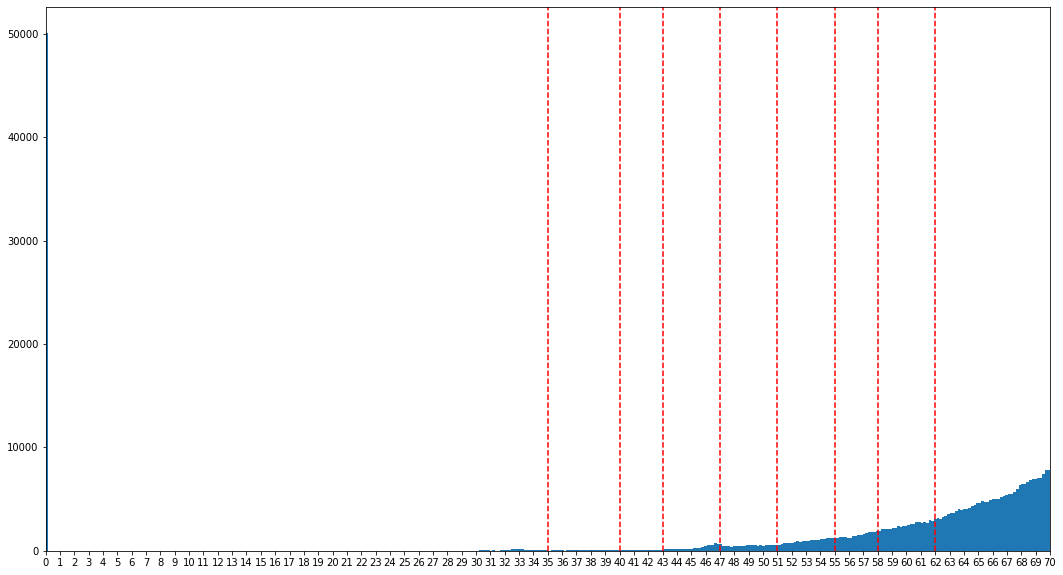

In [6]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, diff_and_replace=True)

DEMO_PHASE = "train"
DEMO_ID = 0
DEMO_SANDY = True #"" in DEMO_PHASE

ingest_args = dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
        )
    },
    io=(
        {
            "env": "Sandy",
            "rep": 0,
            "matcher": [(exot.util.wrangle.Matcher("power", "msr", ["rapl_domain"], ['pp0']),None)],
        }
        if DEMO_SANDY
        else {
            "env": "Haswell",
            "rep": 0,
            "matcher": [(exot.util.wrangle.Matcher("power", "msr", ["rapl_domain"], ['pp0']),None)],
        }
    ),
)

demo_run = experiment.phases[DEMO_PHASE][DEMO_ID]
demo_run.ingest(**ingest_args)

with PerformanceRunPlotter(demo_run) as plotter:
    plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
    plotter.plot_symstream()

quantisation_thresholds = experiment.environments_apps_zones[
    ingest_args['io']['env']]['snk']['zone_config'].power_thresholds[
    demo_run.i_rdpstream.columns[-1].split(':')[-2]]

plt.figure()
plt.hist(demo_run.i_rdpstream['power_msr:rapl_domain:pp0:W'], bins='auto')
plt.xticks(np.arange(0, max(demo_run.i_rdpstream['power_msr:rapl_domain:pp0:W'])+1, 1.0))
for threshold in quantisation_thresholds[1:]:
    plt.axvline(x=threshold, color='red', linestyle='--')
plt.xlim([0,70])

In [7]:
raise Exception("Are you sure?")

Exception: Are you sure?

## Analyse

1. Deserialisation

In [8]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, diff_and_replace=True)

2020-03-30 18:44:55 :: unpicked an experiment instance <PerformanceExperiment at 0x7f94a8dceb38 with PowerCC channel, configured>
2020-03-30 18:44:55 :: configs from pickle and directory differ at [{'path': ('save_path',), 'left': 'data', 'right': './data'}]
2020-03-30 18:44:56 :: environments from pickle and directory differ at [{'path': ('Sandy', 'host', 'power_thresholds', 'pp0'), 'left': [0.0, 35.0, 39.0, 43.0, 47.0, 50.5, 53.75, 57.5, 61.0], 'right': [0.0, 35.0, 40.0, 43.0, 47.0, 51.0, 55.0, 58.0, 62.0]}]
2020-03-30 18:44:56 :: git commit of unpickled experiment repo '72570632' does not match the commit in which the unpickling was performed 'b9fe78b3'
2020-03-30 18:44:56 :: bootstrapped layer 'src' with SourcePassthrough
2020-03-30 18:44:56 :: bootstrapped layer 'lne' with MedianLineCoding
2020-03-30 18:44:56 :: bootstrapped layer 'rdp' with QuantCoreActivation
2020-03-30 18:44:56 :: bootstrapped layer 'io' with TimeValue


2. Analyse the experiment

_Define the analysis arguments and phase mappings_

In [9]:
to_evaluate = "normal"

analysis_args = {
    "Sandy": dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=None)
        )
    },
        io={
            "matcher": [(exot.util.wrangle.Matcher("power", "msr", ["rapl_domain"], ['pp0']),None)]
        },
    ),
    "Haswell": dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(), 
            sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=None)
        )
    },
        io={
            "matcher": [(exot.util.wrangle.Matcher("power", "msr", ["rapl_domain"], ['pp0']),None)],
        },
    ),
}

phase_mappings = {
    "Haswell": {
        "normal": ["train", "eval"],
    },
    "Sandy": {
        "normal": ["train", "eval"],
    },
}

3. Calculate the performance metrics

In [10]:
del experiment.performance_metrics

In [11]:
for env in phase_mappings:
    experiment.calculate_performance_metrics(
        phase_mapping=dict([tuple(phase_mappings[env][to_evaluate])]),
        envs=[env],
        reps=[],
        use_levensthein=True,
        **analysis_args[env],
    )

2020-03-30 18:45:10 :: analysing performance for phases: train -> eval, environments ['Haswell']
2020-03-30 19:10:26 :: analysing performance for phases: train -> eval, environments ['Sandy']


_Show the performance metrics..._

In [12]:
experiment.performance_metrics.head()

,phase,trained_with,environment,bit_rate,symbol_rate,repetition,bit_error,symbol_error,matcher,variable
0,train,,Haswell,1.0,1,0,0.498667,0.498667,"<Matcher quantity='power', method='msr', value...",power_msr
1,eval,train,Haswell,1.0,1,0,0.494000,0.494000,"<Matcher quantity='power', method='msr', value...",power_msr
2,train,,Haswell,1.0,1,1,0.498667,0.498667,"<Matcher quantity='power', method='msr', value...",power_msr
3,eval,train,Haswell,1.0,1,1,0.494000,0.494000,"<Matcher quantity='power', method='msr', value...",power_msr
4,train,,Haswell,1.0,1,2,0.498667,0.498667,"<Matcher quantity='power', method='msr', value...",power_msr


_...and the aggregated performance metrics (mean of repetitions)_

In [13]:
experiment.aggregate_performance_metrics()

,phase,trained_with,environment,bit_rate,symbol_rate,matcher,variable,bit_error,symbol_error
0,eval,train,Haswell,1.0,1,"<Matcher quantity='power', method='msr', value...",power_msr,0.494000,0.494000
1,eval,train,Haswell,10.0,10,"<Matcher quantity='power', method='msr', value...",power_msr,0.494800,0.494800
2,eval,train,Haswell,20.0,20,"<Matcher quantity='power', method='msr', value...",power_msr,2.293085,2.293085
3,eval,train,Haswell,30.0,30,"<Matcher quantity='power', method='msr', value...",power_msr,2.263133,2.263133
4,eval,train,Haswell,40.0,40,"<Matcher quantity='power', method='msr', value...",power_msr,0.798171,0.798171
5,eval,train,Haswell,50.0,50,"<Matcher quantity='power', method='msr', value...",power_msr,0.708718,0.708718
6,eval,train,Haswell,60.0,60,"<Matcher quantity='power', method='msr', value...",power_msr,3.266251,3.266251
7,eval,train,Haswell,70.0,70,"<Matcher quantity='power', method='msr', value...",power_msr,0.689069,0.689069
8,eval,train,Haswell,80.0,80,"<Matcher quantity='power', method='msr', value...",power_msr,0.678571,0.678571
9,eval,train,Haswell,90.0,90,"<Matcher quantity='power', method='msr', value...",power_msr,0.487067,0.487067


4. Serialise the experiment with the calculated performance metrics

In [14]:
experiment.write()

5. Get aggregated performance metrics for each environment and phase and output as CSV

In [15]:
for env in phase_mappings:
    eval_phase = phase_mappings[env][to_evaluate][-1]
    BERs = wrangle.filter_data(
        experiment.aggregate_performance_metrics(), environment=env, phase=eval_phase
    )

    PREFIX = ("interference" if "interference" in NB_EXPERIMENT else "baseline")

    pd.DataFrame({"bit_rate": BERs["bit_rate"], "bit_error": BERs["bit_error"]}).to_csv(
        experiment.path.joinpath("performance_{}_{}_{}.dat".format(PREFIX, NB_EXPERIMENT.split('_')[-1], 
                                                             env)),
        sep=",",
        encoding="utf-8",
        index=False,
    )

6. Plot performance metrics

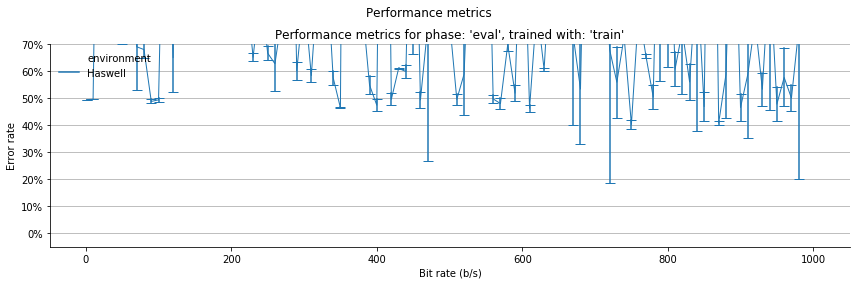

In [16]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics()